In [27]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd

# Setting Up BigQuery

For Anaconda setup, install BigQuery with:
```bash
conda install conda-forge::google-cloud-bigquery
```

Then we need to setup Google Cloud SDK for Authentication and Project Quota:
```bash
brew install --cask google-cloud-sdk
gcloud init
gcloud auth login
gcloud auth application-default login --project=<project-id>
gcloud config set project machine-learning-course-452315
```

Now we need to setup the Project Quota for the BigQuery client:
```bash
conda env config vars set GOOGLE_CLOUD_PROJECT=<project-id>
conda deactivate
conda activate base
```
(Note that we used base for the environment of anaconda, you can change it if you use a different environment -- prod for example)

To check if the project is setup, use:
```bash
echo $GOOGLE_CLOUD_PROJECT
```

We can now query some dataset !

In [6]:
client = bigquery.Client()

dataset_ref = client.dataset('github_repos', project="bigquery-public-data")

tables = list(client.list_tables(dataset_ref))

### We will begin by listing the tables inside of the Dataset.

Get the list of tables using the client library, and get a list of tables string using `table_id`.

In [8]:
[table.table_id for table in tables]

['commits',
 'contents',
 'files',
 'languages',
 'licenses',
 'sample_commits',
 'sample_contents',
 'sample_files',
 'sample_repos']

# Project:

For the following questions, here is what we are planning to do:
- Create a SQL query that will get the data from BigQuery
- Save the dataframe into .csv file
- Do some data visualization

# Questions:

1. What is the distribution of commits per repository?
2. Which authors have the most commits?
3. What is the average number of commits per year?

### Question 1:
1. What is the distribution of commits per repository? => Count commits per repository
- Query + Get data from BigQuery:

In [16]:
commits_per_repo_query = """
SELECT repository, 
       COUNT(1) AS commit_count
  FROM `bigquery-public-data.github_repos.commits` AS commits, commits.repo_name AS repository
 GROUP BY 1
 ORDER BY 2 DESC
"""

# 10 GB is 10**10
# for this query we need 100 GB of data processing minimum
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10*10**10)
query_job = client.query(commits_per_repo_query, safe_config)

df = query_job.to_dataframe()

df.head()

,repository,commit_count
0,chromium/chromium,1197167
1,shenzhouzd/update,1188925
2,scheib/chromium,1104843
3,cminyard/linux-live-app-coredump,1085904
4,frustreated/linux,1074491


- Save the dataframe into a <em>.csv</em> file!<br/>
We don't have to worry about cost anymore.

In [20]:
df.to_csv('commits_per_repo.csv', index=False)

We will now get our data from the <em>.csv</em> file to construct a new dataframe. <br/>

In [33]:
df = pd.read_csv('commits_per_repo.csv')

df.head()

,repository,commit_count
0,chromium/chromium,1197167
1,shenzhouzd/update,1188925
2,scheib/chromium,1104843
3,cminyard/linux-live-app-coredump,1085904
4,frustreated/linux,1074491


- Do some visualizations. <br/>

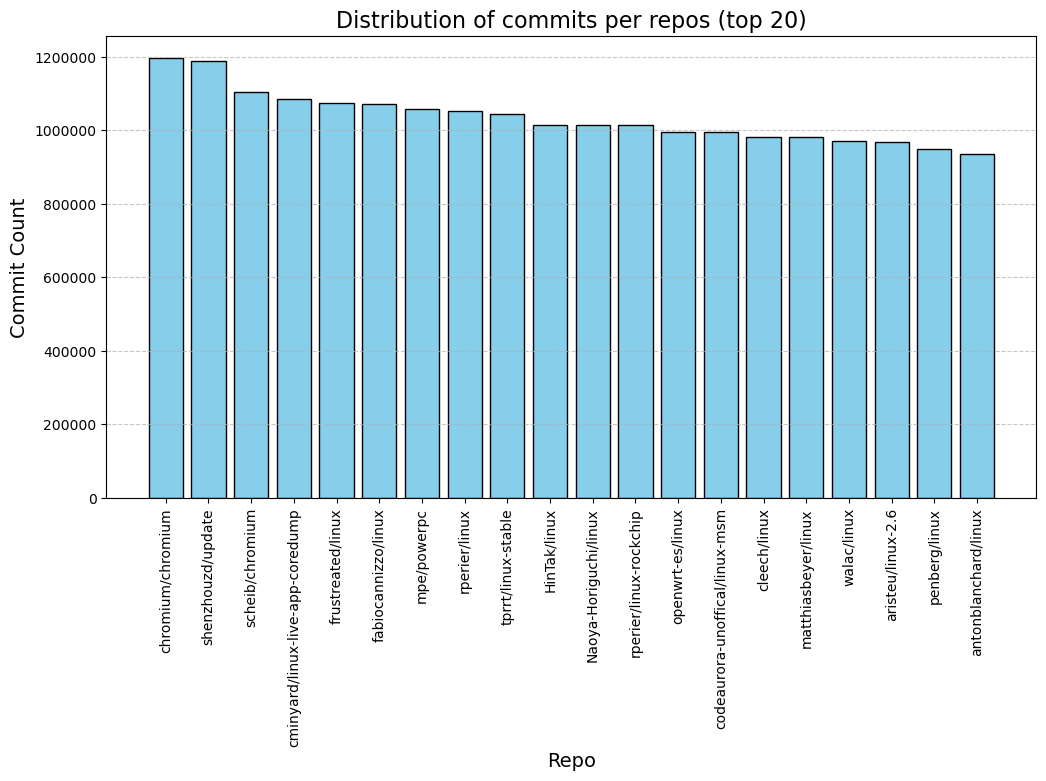

In [37]:
df = df.head(20)

df = df.set_index('repository')

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['commit_count'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel("Repo", fontsize=14)
plt.ylabel("Commit Count", fontsize=14)
plt.title("Distribution of commits per repos (top 20)", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Format y-axis ticks to show GB instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')

# Show grid for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

### Question 2:
2. Which authors have the most commits?
<br />
- Query + Get data from BigQuery:

In [41]:
authors_commits_query = """
SELECT author.name, 
       COUNT(1) AS commit_count
  FROM `bigquery-public-data.github_repos.commits` AS commits
 GROUP BY 1
 ORDER BY 2 DESC
"""

# 10 GB is 10**10
# for this query we only need 3 GB of data processing minimum
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(authors_commits_query, safe_config)

df = query_job.to_dataframe()

df.head()

,name,commit_count
0,shenzhouzd,1188430
1,dependabot[bot],622184
2,Duane F. King,597940
3,Marge Spiderworthy,495786
4,Curt Clifton,384915


- Save the dataframe into a <em>.csv</em> file!<br/>
We don't have to worry about cost anymore.

In [48]:
df.to_csv('authors_commits.csv', index=False)

We will now get our data from the <em>.csv</em> file to construct a new dataframe. <br/>

In [50]:
df = pd.read_csv('authors_commits.csv')

df.head()

,name,commit_count
0,shenzhouzd,1188430
1,dependabot[bot],622184
2,Duane F. King,597940
3,Marge Spiderworthy,495786
4,Curt Clifton,384915


- Do some visualizations. <br/>

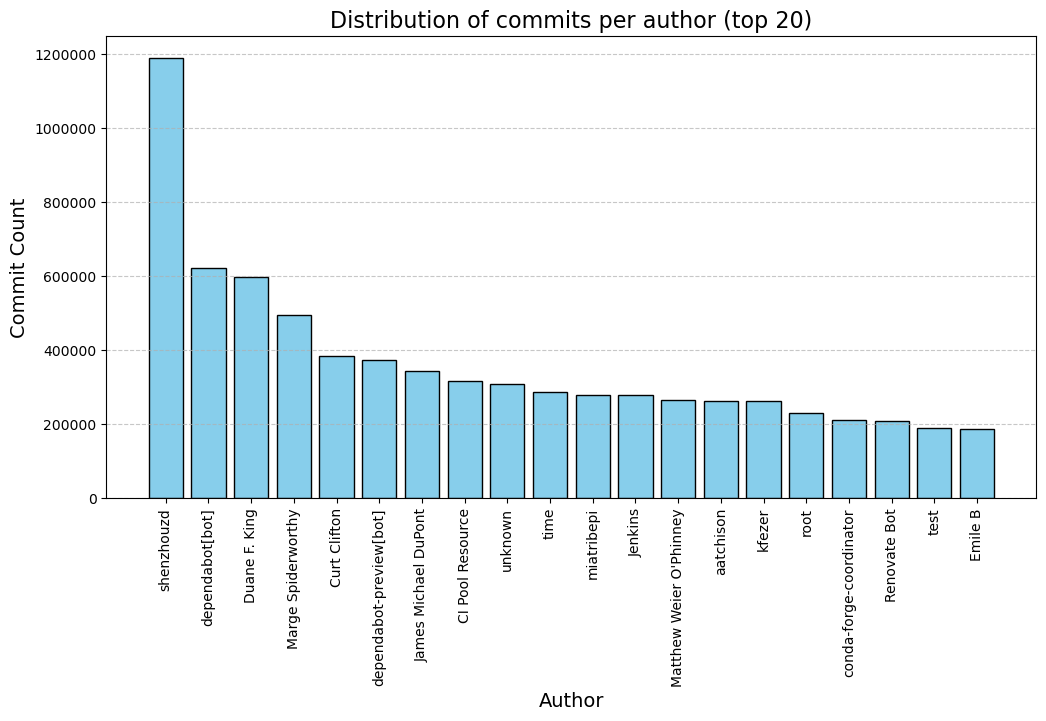

In [62]:
df = df.head(20)

df = df.set_index('name')

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['commit_count'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel("Author", fontsize=14)
plt.ylabel("Commit Count", fontsize=14)
plt.title("Distribution of commits per author (top 20)", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Format y-axis ticks to show GB instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')

# Show grid for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

### Question 3:
3. What is the average number of commits per year?
- Query + Get data from BigQuery:

In [67]:
commits_per_year_query = """
SELECT EXTRACT(YEAR FROM DATE(TIMESTAMP_SECONDS(committer.date.seconds))) AS commit_year, 
       COUNT(1) AS commit_count
  FROM `bigquery-public-data.github_repos.commits` AS commits
 WHERE EXTRACT(YEAR FROM DATE(TIMESTAMP_SECONDS(committer.date.seconds))) <= 2025
 GROUP BY 1
 ORDER BY 1 DESC
"""

# 10 GB is 10**10
# for this query we only need 3 GB of data processing minimum
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(commits_per_year_query, safe_config)

df = query_job.to_dataframe()

df.head()

,commit_year,commit_count
0,2025,438
1,2024,735
2,2023,734
3,2022,6162218
4,2021,9117968


- Save the dataframe into a <em>.csv</em> file!<br/>
We don't have to worry about cost anymore.

In [69]:
df.to_csv('commits_per_year.csv', index=False)

We will now get our data from the <em>.csv</em> file to construct a new dataframe. <br/>

In [73]:
df = pd.read_csv('commits_per_year.csv')

df.head()

,commit_year,commit_count
0,2025,438
1,2024,735
2,2023,734
3,2022,6162218
4,2021,9117968


- Do some visualizations. <br/>

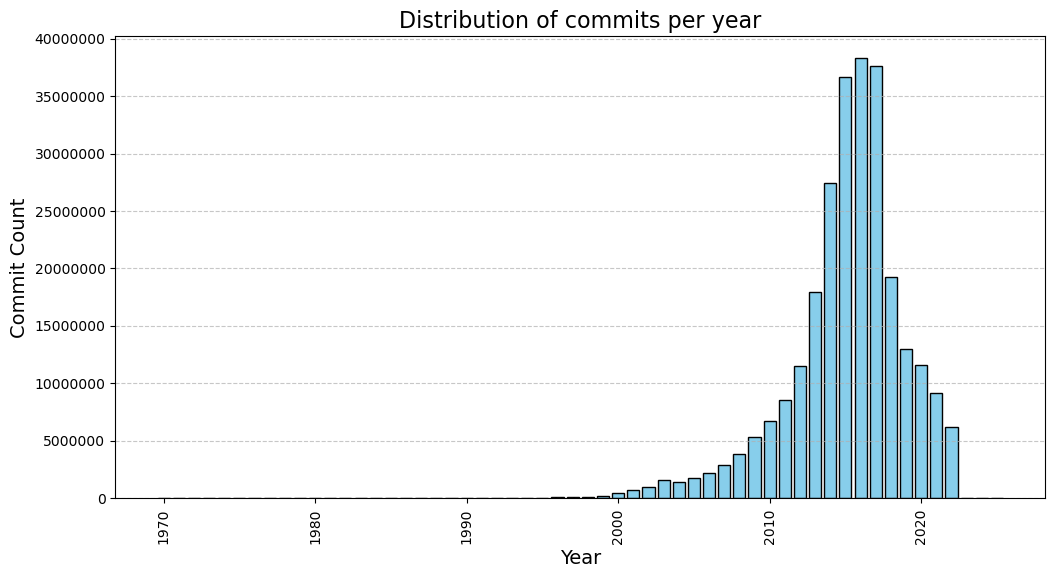

In [77]:
df = df.set_index('commit_year')

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['commit_count'], color='skyblue', edgecolor='black')

# Labels and title
plt.xlabel("Year", fontsize=14)
plt.ylabel("Commit Count", fontsize=14)
plt.title("Distribution of commits per year", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Format y-axis ticks to show GB instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')

# Show grid for better readability
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()